In [1]:
# TODO: imports
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
tf.reset_default_graph()

In [3]:
(x_train, y_train), (x_test, y_test)= mnist.load_data()
# print("Train pics: {}, Train labels: {}, Test pics: {}, Test labels: {}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

x_train_list = []
y_train_list = []

for i in range(0, 20):
    x_train_list.append(x_train[i])
    y_train_list.append(y_train[i])

x_train_list = np.asarray(x_train_list)
y_train_list = np.asarray(y_train_list)

In [4]:
def round_percent(num):
    num *= 100
    num = round(num, 1)
    return num

In [5]:
# TODO: Model class
class CNN:
    def __init__(self, image_height, image_width, channels, num_classes):
        self.input_layer = tf.placeholder(dtype=tf.float32, shape=[None, image_height, image_width, channels])
        
        conv_layer_1 = tf.layers.conv2d(self.input_layer, filters=32, kernel_size=[2, 2], padding="same", activation=tf.nn.relu)
        pooling_layer_1 = tf.layers.max_pooling2d(conv_layer_1, pool_size=[2, 2], strides=2)
        
        conv_layer_2 = tf.layers.conv2d(pooling_layer_1, filters=32, kernel_size=[2, 2], padding="same", activation=tf.nn.relu)
        pooling_layer_2 = tf.layers.max_pooling2d(conv_layer_2, pool_size=[2, 2], strides=2)
        
        conv_layer_3 = tf.layers.conv2d(pooling_layer_2, filters=32, kernel_size=[2, 2], padding="same", activation=tf.nn.relu)
        pooling_layer_3 = tf.layers.max_pooling2d(conv_layer_3, pool_size=[2, 2], strides=2)
        
        flattened_pooling = tf.layers.flatten(pooling_layer_3)
        dense_layer = tf.layers.dense(flattened_pooling, 1024, activation=tf.nn.relu)
        
        dropout = tf.layers.dropout(dense_layer, rate=0.4, training=True)
        outputs = tf.layers.dense(dropout, num_classes) 
        
        self.choice = tf.argmax(outputs, axis=1)
        
        self.probability = tf.nn.softmax(outputs)
        self.labels = tf.placeholder(dtype=tf.float32, name="labels")
        self.accuracy, self.accuracy_op = tf.metrics.accuracy(self.labels, self.choice)
        one_hot_labels = tf.one_hot(indices=tf.cast(self.labels, dtype=tf.int32), depth=num_classes)
        self.loss = tf.losses.softmax_cross_entropy(onehot_labels=one_hot_labels, logits=outputs)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-3)
        self.train_operation = optimizer.minimize(loss=self.loss, global_step=tf.train.get_global_step())
        
        
        


In [6]:
# TODO: initialize variables
steps = 5000
batch_size = 32  # 32
image_height = 28
image_width = 28
color_channels = 1
num_classes = 10
test_pics = []
test_labels = []

model_name = "model"

path = "./checkpoints/"

if os.path.exists(path):
    load_checkpoint = True
else:
    load_checkpoint = False

pre_performance_graph = np.array([])
performance_graph = np.array([])

for i in range(0, 10):
    test_pics.append(x_test[i])
    test_labels.append(y_test[i])

In [7]:
# TODO: run model
dataset = tf.data.Dataset.from_tensor_slices((x_train_list, y_train_list))    
dataset = dataset.shuffle(buffer_size=y_train.shape[0])
dataset = dataset.batch(batch_size)
dataset = dataset.repeat()

dataset_iterator = dataset.make_initializable_iterator()
next_element = dataset_iterator.get_next()

cnn = CNN(image_height, image_width, color_channels, num_classes)

saver = tf.train.Saver(max_to_keep=2)

if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    if load_checkpoint:
        checkpoint = tf.train.get_checkpoint_state(path)
        saver.restore(sess, checkpoint.model_checkpoint_path)
    else:
        sess.run(tf.global_variables_initializer())
    
    sess.run(tf.local_variables_initializer())
    sess.run(dataset_iterator.initializer)
    
    for step in range(steps):
        current_batch = sess.run(next_element)
        
        batch_inputs = current_batch[0]
        batch_labels = current_batch[1]
        
        batch_inputs = batch_inputs.reshape(-1, image_height, image_width, color_channels)
        
        sess.run((cnn.train_operation, cnn.accuracy_op), 
                 feed_dict={cnn.input_layer:batch_inputs, cnn.labels:batch_labels})
        if step < 1000 and step % 100 == 0:
            pre_performance_graph = np.append(pre_performance_graph, sess.run(cnn.accuracy))
            
            current_accuracy = sess.run(cnn.accuracy)
            current_accuracy = round_percent(current_accuracy)
            print("[PRE] Current accuracy at step {} is {}%".format(str(step), str(current_accuracy)))
            
        if step % 1000 == 0 and step > 0:
            performance_graph = np.append(performance_graph, sess.run(cnn.accuracy))
            
            current_accuracy = sess.run(cnn.accuracy)
            current_accuracy = round_percent(current_accuracy)
            print("Current accuracy at step {} is {}%".format(str(step), str(current_accuracy)))
            print("Saving Checkpoint...")
            saver.save(sess, path + model_name, step)
        
    print("Saving final checkpoint for session...")
    saver.save(sess, path + model_name, step)
        
    sess.close()
            

W0707 23:16:33.167087 4617127360 deprecation.py:323] From <ipython-input-7-cbe8e088ef67>:7: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
W0707 23:16:33.175440 4617127360 deprecation.py:323] From <ipython-input-5-c803421d8694>:6: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0707 23:16:33.178283 4617127360 deprecation.py:506] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) w

[PRE] Current accuracy at step 0 is 15.0%
[PRE] Current accuracy at step 100 is 83.1%
[PRE] Current accuracy at step 200 is 91.0%
[PRE] Current accuracy at step 300 is 93.9%
[PRE] Current accuracy at step 400 is 95.3%
[PRE] Current accuracy at step 500 is 96.2%
[PRE] Current accuracy at step 600 is 96.8%
[PRE] Current accuracy at step 700 is 97.3%
[PRE] Current accuracy at step 800 is 97.6%
[PRE] Current accuracy at step 900 is 97.9%
Current accuracy at step 1000 is 98.1%
Saving Checkpoint...
Current accuracy at step 2000 is 99.0%
Saving Checkpoint...


W0707 23:16:56.263899 4617127360 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Current accuracy at step 3000 is 99.3%
Saving Checkpoint...
Current accuracy at step 4000 is 99.5%
Saving Checkpoint...
Saving final checkpoint for session...


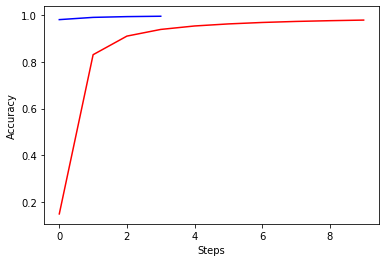

In [8]:
# TODO: graph running accuracy
plt.figure().set_facecolor('white')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.plot(performance_graph, 'b-')
plt.plot(pre_performance_graph, 'r-')

In [9]:
# TODO: check final accuracy
with tf.Session() as sess:
    for i in range(0, len(test_pics)):
        test_pics[i] = test_pics[i].reshape(image_height, image_width, color_channels)
    
    checkpoint = tf.train.get_checkpoint_state(path)
    saver.restore(sess, checkpoint.model_checkpoint_path)
    
    sess.run(tf.local_variables_initializer())
    
    for image, label in zip(test_pics, test_labels):
        sess.run(cnn.accuracy_op, feed_dict={cnn.input_layer:[image], cnn.labels:label})
    
    total_accuracy = sess.run(cnn.accuracy)
    total_accuracy = round_percent(total_accuracy)
    print("Final Accuracy: {}%".format(total_accuracy))

W0707 23:17:12.651451 4617127360 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Final Accuracy: 40.0%


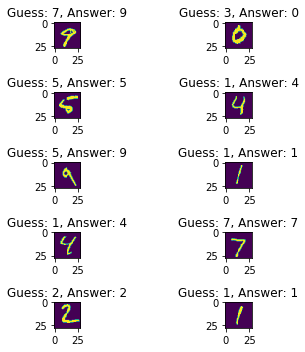

In [10]:
# TODO: test model
with tf.Session() as sess:
    for i in range(0, len(test_pics)):
        test_pics[i] = test_pics[i].reshape(-1, image_height, image_width, color_channels)
    
    checkpoint = tf.train.get_checkpoint_state(path)
    saver.restore(sess, checkpoint.model_checkpoint_path)
    
    indexes = np.random.choice(len(test_pics), 10, replace=False)
    
    rows = 5
    cols = 2
    
    fig, axes = plt.subplots(rows, cols, figsize=(5, 5))
    fig.patch.set_facecolor('white')
    image_count = 0
    
    for i in indexes:
        image_count += 1
        sub = plt.subplot(rows, cols, image_count)
        img = test_pics[i]
        
        img = img.reshape(28, 28)
        plt.imshow(img)
        
        guess = sess.run(cnn.choice, feed_dict={cnn.input_layer:test_pics[i]})
        
        guess_name = str(guess[0])
        actual_name = str(test_labels[i])
        
        sub.set_title("Guess: {}, Answer: {}".format(guess_name, actual_name))
    
    plt.tight_layout()


In [11]:
tf.Session().close()